In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from itertools import combinations
import pandas as pd
from scipy.spatial import distance
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.metrics import silhouette_score
import seaborn as sns
from math import log2

C:\Users\hugma\AppData\Local\Temp\ipykernel_2520\1378048044.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
filelocation_TET = 'NDT_all_12thDec_uncleaned.csv'
feelings = ['MetaAwareness','Presence','PhysicalEffort','MentalEffort','Boredom', 'Receptivity', 'EmotionalIntensity', 'Clarity', 'Release', 'Bliss', 'Embodiment', 'Insightfulness', 'Anxiety', 'SpiritualExperience']
header = "Week"
no_dimensions = 2
colours = {0:'red',1:'green',2:'blue',3:'orange',4:'pink',5:'yellow'}
colours_list = ['red','green','blue','orange','pink','yellow']
n_clust = 3
headers = {'Subject':0, 'Week':1, 'Session':2}
feelings_diffs = ['MetaAwareness_diff', 'Presence_diff', 'PhysicalEffort_diff',
       'MentalEffort_diff', 'Boredom_diff', 'Receptivity_diff',
       'EmotionalIntensity_diff', 'Clarity_diff', 'Release_diff', 'Bliss_diff',
       'Embodiment_diff', 'Insightfulness_diff', 'Anxiety_diff',
       'SpiritualExperience_diff']
lcm = 332640
n_rep = 1
no_of_jumps = 1

In [3]:
class csv_splitter:

    def __init__(self,excel_file_name):
        self.excel_file_location = f'c:\\Users\\hugma\\diss\\{excel_file_name}'
        self.dataframes = None
    def read_excel(self):
        try:
            df_excel_file_name = pd.read_csv(self.excel_file_location)
            return df_excel_file_name
        except Exception as e:
            print(f"error reading Excel file: {e}")
    def split_by_header(self,df_excel_file_name, heading):
        if heading not in df_excel_file_name.columns:
            print(f"Error: '{heading}' not found in DataFrame columns.")
            return None
        heading_values = df_excel_file_name[heading].unique()
        split_df = {value: df_excel_file_name[df_excel_file_name[heading] == value] for value in heading_values}
        split_df_array = [[key, value] for key, value in split_df.items()]
        return split_df, split_df_array

In [4]:
class principal_component_finder:

    def __init__(self,csv_file, feelings,no_dimensions):
        self.csv_file_TET = csv_file[feelings]
        corr_matrix = self.csv_file_TET.corr()
        pca = PCA(n_components=no_dimensions)
        self.principal_components=pca.fit_transform(corr_matrix)
        self.explained_variance_ratio = pca.explained_variance_ratio_
    def PCA_TOT(self):
        df_TET_feelings_prin = self.csv_file_TET.dot(self.principal_components)
        for i in range(0,self.principal_components.shape[1]):
            y_values = []
            for j in range(0,len(feelings)):
                y_values.append(self.principal_components[j][i])
           # plt.figure()
            #plt.bar(feelings,y_values)
            #plt.title(f'principal componant {i+1}')
            #plt.xticks(rotation=45, ha='right')
        #plt.figure()
        #plt.scatter(df_TET_feelings_prin[0],df_TET_feelings_prin[1], s=0.5)
        #plt.xlabel('principal componant 1 (bored/effort)')
        #plt.ylabel('principal componant 2 (calm)')
        #plt.xlim(-6,6)
        #plt.ylim(-1,2)
        
        return self.principal_components, self.explained_variance_ratio, df_TET_feelings_prin
    def PCA_split(self,split_df_array):
        split_df_array_TET = [[split_df_array[i][0],split_df_array[i][1][feelings]] for i in range(0,len(split_df_array))]
        split_csv_TET = {split_df_array_TET[i][0]: split_df_array_TET[i][1] for i in range(0,len(split_df_array))}
        df_TET_feelings_prin_dict = {name: split_csv_TET[name].dot(self.principal_components) for name in split_csv_TET.keys()}
        #for key,value in df_TET_feelings_prin_dict.items():
           # plt.figure()
            #plt.scatter(value[0],value[1],s=0.5)
           # plt.title(key)
            #plt.xlabel('principal componant 1 (bored/effort)')
           # plt.ylabel('principal componant 2 (calm)')
            #plt.xlim(-6,6)
           # plt.ylim(-1,2)
            #plt.show()
        return df_TET_feelings_prin_dict

In [5]:
csv_splitter_instance = csv_splitter(filelocation_TET)
df_csv_file_original = csv_splitter_instance.read_excel()
split_df, split_csv_array = csv_splitter_instance.split_by_header(df_csv_file_original,header)

In [6]:
principal_component_finder_instance = principal_component_finder(df_csv_file_original,feelings,no_dimensions)
principal_components, explained_variance_ratio, df_TET_feelings_prin = principal_component_finder_instance.PCA_TOT()
df_TET_feelings_prin_dict = principal_component_finder_instance.PCA_split(split_csv_array)

In [7]:
x_values=[]
y_values = []
for no_of_jumps in range(1,30):
    split_dict_skip = {}
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        split_dict_skip[(subject, week, session)] = group.iloc[::no_of_jumps].copy()
    df_csv_file = pd.concat([df for df in split_dict_skip.values()])
    for feeling in feelings: 
    
        df_csv_file[f'{feeling}_diff'] = -df_csv_file[feeling].diff(-1)
    split_dict = {}
    for (subject, week, session), group in df_csv_file.groupby(['Subject', 'Week', 'Session']):
        split_dict[(subject, week, session)] = group.copy()
        differences_array = pd.concat([df[:-1] for df in split_dict.values()])
    numbers = []
    for i in range(differences_array.shape[0]):
        numbers.append(i)
    
    differences_array_MI = differences_array.copy()
    differences_array_MI['number'] = numbers
    wcss_best = 10000000
    labels_fin = []
    cluster_centres_fin = []
    for i in range(0,1000):
        kmeans = KMeans(3)
        kmeans.fit(differences_array.iloc[:,-14:])
        labels = kmeans.labels_
        cluster_centres = kmeans.cluster_centers_
        wcss = kmeans.inertia_
        if wcss< wcss_best:
            wcss_best = wcss
            labels_fin = labels
            cluster_centres_fin = cluster_centres
    differences_array_MI['labels unnormalised vectors'] = labels_fin
    downsampled_groups = []
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        downsampled = group.iloc[::no_of_jumps].copy()
        downsampled = downsampled[:-1]
        downsampled['Original_Index'] = downsampled.index
        downsampled_groups.append(downsampled)

    # Concatenate downsampled groups into a DataFrame
    df_downsampled = pd.concat(downsampled_groups)
    df_downsampled['Cluster_Label'] = labels_fin
    df_csv_file_original['Cluster_Label'] = np.nan
    for _, row in df_downsampled.iterrows():
        original_index = row['Original_Index']
        label = row['Cluster_Label']
        # Find the group of the original index
        group_info = df_csv_file_original.loc[original_index, ['Subject', 'Week', 'Session']]
        group_mask = (df_csv_file_original['Subject'] == group_info['Subject']) & \
                    (df_csv_file_original['Week'] == group_info['Week']) & \
                    (df_csv_file_original['Session'] == group_info['Session'])
        group_indices = df_csv_file_original[group_mask].index
        # Find the position of the original index within its group
        pos_in_group = list(group_indices).index(original_index)
        # Calculate the start and end indices to assign labels within the group based on no_of_jumps
        start_idx = pos_in_group - (pos_in_group % no_of_jumps)
        end_idx = min(start_idx + no_of_jumps, len(group_indices))
        for i in range(start_idx, end_idx):
            df_csv_file_original.at[group_indices[i], 'Cluster_Label'] = label
    for feeling in feelings: 
    

            df_csv_file_original[f'{feeling}_diff'] = -df_csv_file_original[feeling].diff(-1)
    n_entries = 0  # This will count entries considered in the calculation
    correct_assignments = 0

    for i, row in df_csv_file_original.iterrows():
        if not pd.isnull(row['Cluster_Label']) and not row[feelings_diffs].isnull().any():
            # Both cluster label and feelings_diffs are not NaN
            entry = row[feelings_diffs]*no_of_jumps # Extract features
            assigned_cluster = row['Cluster_Label']
            
            # Calculate distances to all cluster centers
            distances = np.array([distance.euclidean(entry, centre) for centre in cluster_centres_fin])
            
            # Find the index of the closest cluster center
            closest_centre_idx = np.argmin(distances)
            
            # Check if the assigned cluster is the closest
            if closest_centre_idx == assigned_cluster:
                correct_assignments += 1
            
            n_entries += 1  # Increment count of entries considered

    if n_entries > 0:
        hughes_measure = correct_assignments / n_entries
    y_values.append(hughes_measure)
    x_values.append(no_of_jumps)

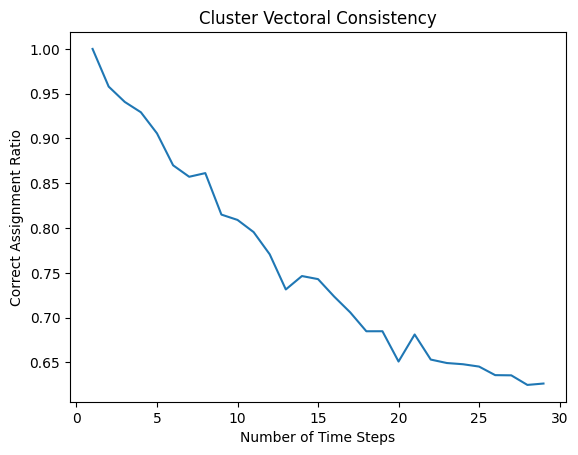

In [8]:
plt.plot(x_values,y_values)
plt.title('Cluster Vectoral Consistency')
plt.xlabel('Number of Time Steps')
plt.ylabel('Correct Assignment Ratio')
plt.savefig("C:/Users/hugma/diss/data/Cluster_Vectoral_consistency")

In [9]:
x_values=[]
y_values = []
for no_of_jumps in range(1,30):
    split_dict_skip = {}
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        split_dict_skip[(subject, week, session)] = group.iloc[::no_of_jumps].copy()
    df_csv_file = pd.concat([df for df in split_dict_skip.values()])
    for feeling in feelings: 
    
        df_csv_file[f'{feeling}_diff'] = -df_csv_file[feeling].diff(-1)
    split_dict = {}
    for (subject, week, session), group in df_csv_file.groupby(['Subject', 'Week', 'Session']):
        split_dict[(subject, week, session)] = group.copy()
        differences_array = pd.concat([df[:-1] for df in split_dict.values()])
    numbers = []
    for i in range(differences_array.shape[0]):
        numbers.append(i)
    
    differences_array_MI = differences_array.copy()
    differences_array_MI['number'] = numbers
    wcss_best = 10000000
    labels_fin = []
    cluster_centres_fin = []
    for i in range(0,1000):
        kmeans = KMeans(3)
        kmeans.fit(differences_array.iloc[:,-14:])
        labels = kmeans.labels_
        cluster_centres = kmeans.cluster_centers_
        wcss = kmeans.inertia_
        if wcss< wcss_best:
            wcss_best = wcss
            labels_fin = labels
            cluster_centres_fin = cluster_centres
   
    differences_array_MI['labels unnormalised vectors'] = labels_fin
    downsampled_groups = []
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        downsampled = group.iloc[::no_of_jumps].copy()
        downsampled = downsampled[:-1]
        downsampled['Original_Index'] = downsampled.index
        downsampled_groups.append(downsampled)

    # Concatenate downsampled groups into a DataFrame
    df_downsampled = pd.concat(downsampled_groups)
    df_downsampled['Cluster_Label'] = labels_fin
    df_csv_file_original['Cluster_Label'] = np.nan
    for _, row in df_downsampled.iterrows():
        original_index = row['Original_Index']
        label = row['Cluster_Label']
        # Find the group of the original index
        group_info = df_csv_file_original.loc[original_index, ['Subject', 'Week', 'Session']]
        group_mask = (df_csv_file_original['Subject'] == group_info['Subject']) & \
                    (df_csv_file_original['Week'] == group_info['Week']) & \
                    (df_csv_file_original['Session'] == group_info['Session'])
        group_indices = df_csv_file_original[group_mask].index
        # Find the position of the original index within its group
        pos_in_group = list(group_indices).index(original_index)
        # Calculate the start and end indices to assign labels within the group based on no_of_jumps
        start_idx = pos_in_group - (pos_in_group % no_of_jumps)
        end_idx = min(start_idx + no_of_jumps, len(group_indices))
        for i in range(start_idx, end_idx):
            df_csv_file_original.at[group_indices[i], 'Cluster_Label'] = label
    for feeling in feelings: 
    

            df_csv_file_original[f'{feeling}_diff'] = -df_csv_file_original[feeling].diff(-1)
    n_entries = 0  # This will count entries considered in the calculation
    correct_assignments = 0

    for i, row in df_csv_file_original.loc[df_csv_file_original['Week']=='Week_3'].iterrows():
        if not pd.isnull(row['Cluster_Label']) and not row[feelings_diffs].isnull().any():
            # Both cluster label and feelings_diffs are not NaN
            entry = row[feelings_diffs]*no_of_jumps # Extract features
            assigned_cluster = row['Cluster_Label']
            
            # Calculate distances to all cluster centers
            distances = np.array([distance.euclidean(entry, centre) for centre in cluster_centres_fin])
            
            # Find the index of the closest cluster center
            closest_centre_idx = np.argmin(distances)
            
            # Check if the assigned cluster is the closest
            if closest_centre_idx == assigned_cluster:
                correct_assignments += 1
            
            n_entries += 1  # Increment count of entries considered

    if n_entries > 0:
        hughes_measure = correct_assignments / n_entries
    y_values.append(hughes_measure)
    x_values.append(no_of_jumps)

KeyboardInterrupt: 

: 

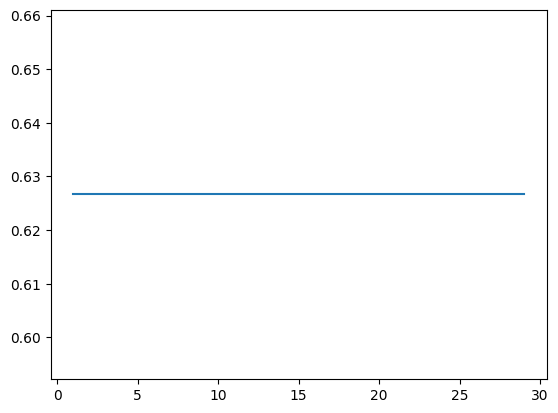

: 

In [ ]:
plt.plot(x_values,y_values)